## Scenario:

"In astronomy, stellar classification is the classification of stars based on their spectral characteristics. The classification scheme of galaxies, quasars, and stars is one of the most fundamental in astronomy. The early cataloguing of stars and their distribution in the sky has led to the understanding that they make up our own galaxy and, following the distinction that Andromeda was a separate galaxy to our own, numerous galaxies began to be surveyed as more powerful telescopes were built. This datasat aims to classificate stars, galaxies, and quasars based on their spectral characteristics."

Data Source from Kaggle:  https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

## Motivation:
- Practice real-world application and contribute to scientific research
- Gain familiarity with the GradientBoostingClassifier Algorithm

## Goals:
- Produce an End-to-End Application for the Scenario. 
- Practice Data Science thinking such as considering data leakage, feature reduction, and evaluation techniques.

## Intuition:
For intuition, I highly suggest visiting [StatQuest with Josh Starmer](https://www.youtube.com/@statquest)'s series on Gradient Boost. [Part 1](https://www.youtube.com/watch?v=3CC4N4z3GJc), [Part 2](https://www.youtube.com/watch?v=2xudPOBz-vs), [Part 3](https://www.youtube.com/watch?v=jxuNLH5dXCs), [Part 4](https://www.youtube.com/watch?v=StWY5QWMXCw&ab_channel=StatQuestwithJoshStarmer).  

## Strategy:
This is a multi-classification problem with numerical features. I have chosen GradientBoostingClassifier from the sklearn library as the algorithm to solve the scenario. I've employed basic EDA such as observing distribution of the dataset and features. Resampling techniques were deployed after discovering class imbalances in the dataset. Weary of the curse of dimensionality, especially with a decision tree algorithm, I will employ feature selection using correlation analysis and ANOVA f-scores. After building the model using default settings, I will use ROC-AUC and Accuracy as evaluation metrics. To see how the model performs across the 3 classes, "STAR", "QSO", and "GALAXY", I will sklean classification report and confusion matrices. 

In [117]:
!pip install -U imbalanced-learn

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from imblearn.under_sampling import RandomUnderSampler


In [119]:
# Read the data
data = pd.read_csv('star_classification.csv')

In [120]:
data.head()

obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354       171  
1  GALAXY  0.779136  10445  58158       427  
2  GALAXY  0.644195   4576  55592       299  
3  GALAXY  0.932346   9149  58039       775  
4  GALAXY  0.116123   6121  56187       842

In [121]:
# small-Medium sized data set with manageable number of features to work with.
data.shape

(100000, 18)

In [122]:
# No missing values, so that is good from a data cleaning perspective.
data.isnull().values.any()

False

In [123]:
## Drop IDs - Not a featuer of the star

data.drop(['obj_ID', 'run_ID','rerun_ID','field_ID','spec_obj_ID','fiber_ID'], axis = 1, inplace = True)

## Exploratory Data Analysis

Let's take a look at the distributions.

Resource: https://www.geeksforgeeks.org/seaborn-kdeplot-a-comprehensive-guide/

In [124]:
data.groupby(['class']).count()

alpha  delta      u      g      r      i      z  cam_col  redshift  \
class                                                                        
GALAXY  59445  59445  59445  59445  59445  59445  59445    59445     59445   
QSO     18961  18961  18961  18961  18961  18961  18961    18961     18961   
STAR    21594  21594  21594  21594  21594  21594  21594    21594     21594   

        plate    MJD  
class                 
GALAXY  59445  59445  
QSO     18961  18961  
STAR    21594  21594

In [125]:
counts = {"Class": ["GALAXY", "QSO", "STAR"] , "Count": [59445, 18961, 21594]}

Text(0.5, 1.0, 'Class Distribution')

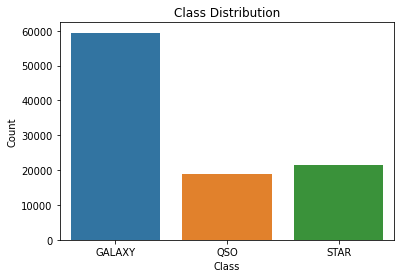

In [126]:
sns.barplot(pd.DataFrame.from_dict(counts), x = 'Class', y = 'Count')
plt.title("Class Distribution")

Because Galaxy represents over half of the classes, this is an example of imbalanced data-set. To remedy this, we need to consider techniques such as over sampling the minorities or undersample the majority. 

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

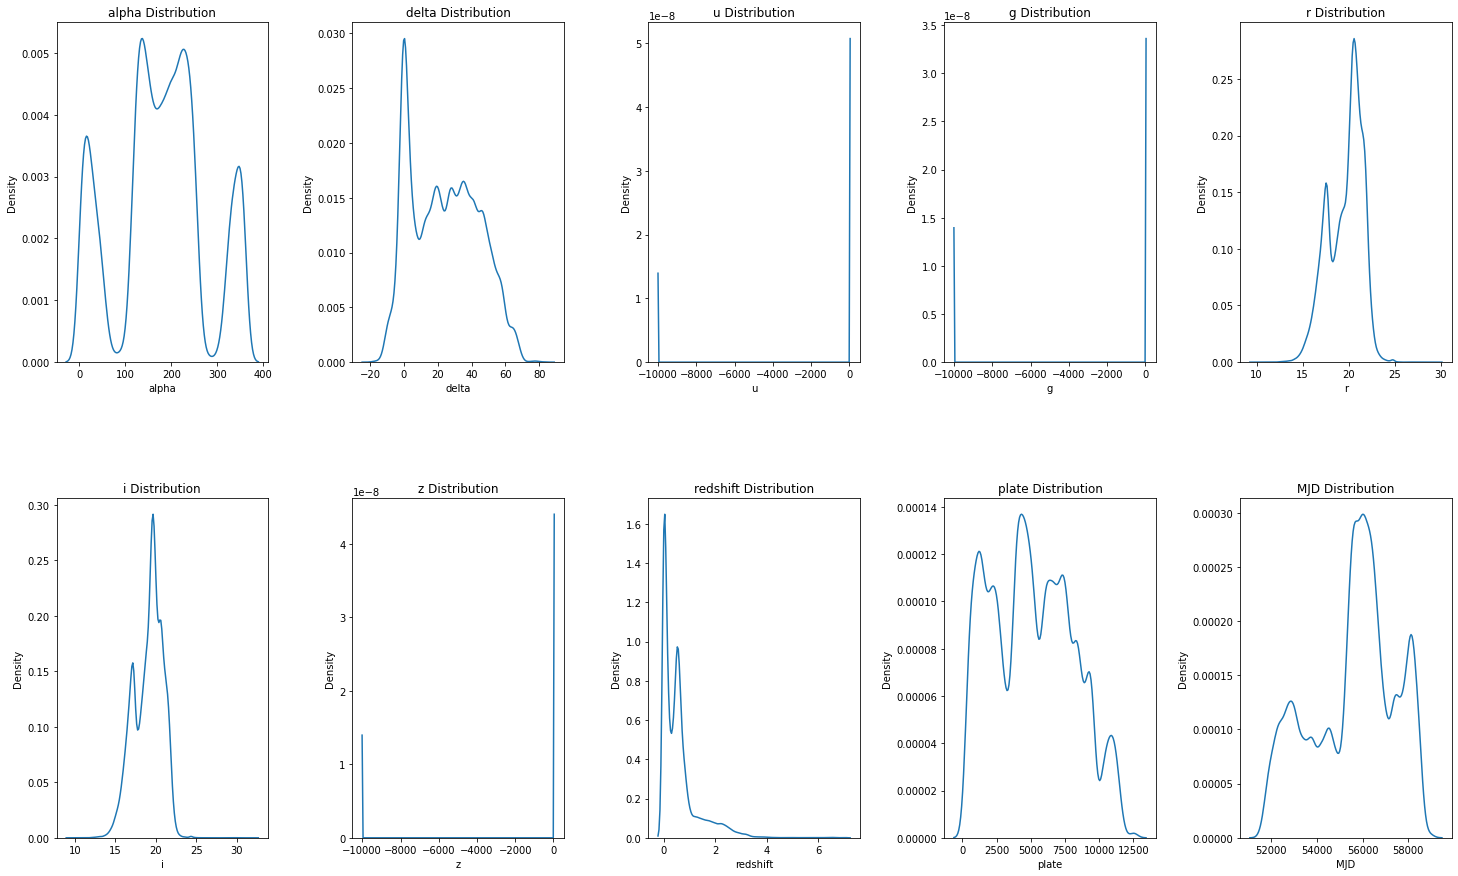

In [127]:
# resources used: https://stackoverflow.com/questions/48579733/seaborn-subplots-keep-different-x-labels
# https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

fig, axes = plt.subplots(2, 5, figsize=(25,15), gridspec_kw={
                           'width_ratios': [3, 3,3,3,3],
                           'height_ratios': [3, 3],
                       'wspace': 0.4,
                       'hspace': 0.4})
#fig.suptitle('Bigger 1 row x 2 columns axes with no data')
#axes[0].set_title('Title of the first chart')
foo = [['alpha','delta','u','g','r'], ['i','z','redshift','plate','MJD']]
for i in range(len(foo)):
    for j in range(len(foo[i])):
        #sns.displot(data, x= foo[i][j], kind="kde")
        sns.kdeplot(ax = axes[i,j], data = data, x= foo[i][j])
        axes[i,j].set_title(f"{foo[i][j]} Distribution")
        
        

In [128]:
## Assign features and target
features = ['alpha','delta','u','g','r','i','z','redshift','plate','MJD']
X = data[features]
y = data['class']

## Split the Data

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .2)

# using these set for the baseline model
X_train_orig = X_train
y_train_orig = y_train

Based on the Class Distribution, we need to apply undersampling to the majority class.

In [130]:
## Apply resampling to the majority class using imblearn
## Reference: https://medium.com/grabngoinfo/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037

# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [131]:
y_train.reset_index().groupby(['class']).count()

index
class        
GALAXY  15164
QSO     15164
STAR    15164

## Correlation Analysis

We see that MJD and plate are highly correlated. r and i are also highly correlated.

Text(0.5, 1.0, 'Correlation Matrix Among Features')

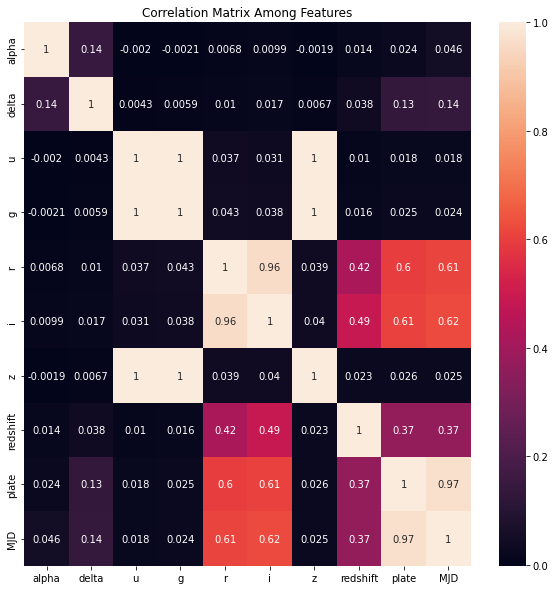

In [132]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(X_train.corr(), annot = True)
plt.title("Correlation Matrix Among Features")

Interpretting the ANOVA F-value. We can conclude that there is some correlation with x, y, and z with our target class

References:
- https://towardsdatascience.com/statistics-in-python-using-anova-for-feature-selection-b4dc876ef4f0
- https://machinelearningmastery.com/feature-selection-with-numerical-input-data/ 

In [133]:
f_classif(X_train, y_train)

(array([1.35004974e+01, 1.29260662e+02, 7.59308631e+00, 8.82542029e+00,
        3.85061879e+03, 6.42566968e+03, 1.23130217e+01, 4.02537313e+04,
        3.79088172e+03, 3.33046360e+03]),
 array([1.37577660e-06, 1.05129465e-56, 5.04562347e-04, 1.47201450e-04,
        0.00000000e+00, 0.00000000e+00, 4.50785116e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]))

Feature 0 alpha: 13.500497
Feature 1 delta: 129.260662
Feature 2 u: 7.593086
Feature 3 g: 8.825420
Feature 4 r: 3850.618790
Feature 5 i: 6425.669682
Feature 6 z: 12.313022
Feature 7 redshift: 40253.731286
Feature 8 plate: 3790.881718
Feature 9 MJD: 3330.463601


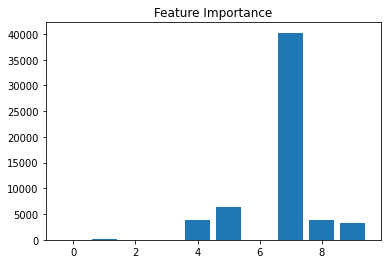

In [134]:
# configure to select all features
fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)

for i in range(len(fs.scores_)):
    print('Feature %d %s: %f' % (i,features[i], fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title("Feature Importance")
plt.show()

Based on the importance score, I will use redshift, plate, and i as part of prediction. I discounted MJD and r because they are highly correlated.

In [135]:
feature_selected = ['redshift','plate','i']

## Build the Baseline Model (all features)

In [136]:
bl_model = GradientBoostingClassifier(random_state = 0)
bl_model.fit(X_train_orig, y_train_orig)

GradientBoostingClassifier(random_state=0)

Train and Test Accuracy score are both in 98%.  This makes me suspicious and require further investigation. 

In [137]:
bl_model.score(X_test, y_test)

0.9767

In [138]:
bl_model.score(X_train_orig, y_train_orig)

0.9779375

In [139]:
print(classification_report(y_test, bl_model.predict(X_test)))

              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     11860
         QSO       0.97      0.91      0.94      3797
        STAR       1.00      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



In [140]:
# run against dummy classifier
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = 42)
dummy_clf.fit(X_train_orig, y_train_orig)

dummy_clf.score(X_test, y_test)


0.4329

In [141]:
dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train_orig, y_train_orig)

dummy_clf.score(X_test, y_test)

0.593

Hyperparameter Tuning was considered but was decided to forgo after reviewing the evaluation metrics.


## Build final model

In [142]:
model = GradientBoostingClassifier(random_state = 0)
model.fit(X_train[feature_selected], y_train)

GradientBoostingClassifier(random_state=0)

In [143]:
# Run predictions
y_pred = model.predict(X_test[feature_selected])

By using 3 features as opposed to using all 10 features originally, our accuracy is still comparable. This reduces the curse of dimensionality. The accuracy score reduced when resampling, but I think this is more realistic to the wild. 


In [144]:
print(f"The Accuracy in the test set is: {model.score(X_test[feature_selected], y_test)}")
print(f"The Accuracy in the test set is: {model.score(X_train[feature_selected], y_train)}")

The Accuracy in the test set is: 0.95555
The Accuracy in the test set is: 0.9498373340367537


In [145]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.96     11860
         QSO       0.89      0.88      0.89      3797
        STAR       1.00      1.00      1.00      4343

    accuracy                           0.96     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.96      0.96      0.96     20000



In [146]:
# Note: [Galaxy, QSO, STAR] is the ordering
probabilities = model.predict_proba(X_test[feature_selected])


In [147]:
roc_auc_score(y_test, probabilities, multi_class='ovr')

0.9870407526195696

## Plotting ROC

In [148]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)


(20000, 3)

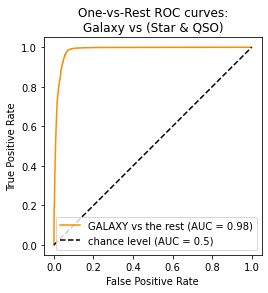

In [149]:
class_of_interest = "GALAXY"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    probabilities[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nGalaxy vs (Star & QSO)")
plt.legend()
plt.show()

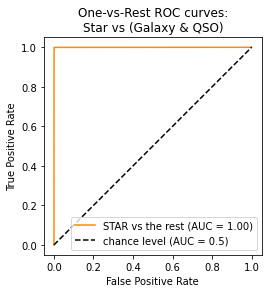

In [150]:
class_of_interest = "STAR"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    probabilities[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nStar vs (Galaxy & QSO)")
plt.legend()
plt.show()


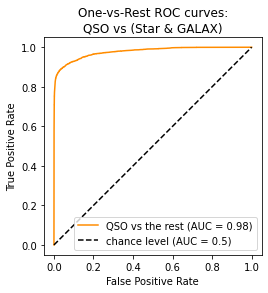

In [151]:
class_of_interest = "QSO"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    probabilities[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nQSO vs (Star & GALAX)")
plt.legend()
plt.show()

## Confusion Matrix

In [152]:
confusion_matrix = multilabel_confusion_matrix(y_test, y_pred)

In [153]:
y_test

75721    GALAXY
80184      STAR
19864      STAR
76699      STAR
92991      STAR
          ...  
32595    GALAXY
29313    GALAXY
37862    GALAXY
53421    GALAXY
42410    GALAXY
Name: class, Length: 20000, dtype: object

In [154]:
y_test.reset_index().groupby(by = 'class').count()

index
class        
GALAXY  11860
QSO      3797
STAR     4343

In [155]:
# Order [Galaxy, QSO, STAR] 
# [TN][FP]
# [FN][TP] 

confusion_matrix

array([[[ 7665,   475],
        [  413, 11447]],

       [[15809,   394],
        [  470,  3327]],

       [[15637,    20],
        [    6,  4337]]])

Text(0.5, 1.0, 'Multi-Confusion Matrix')

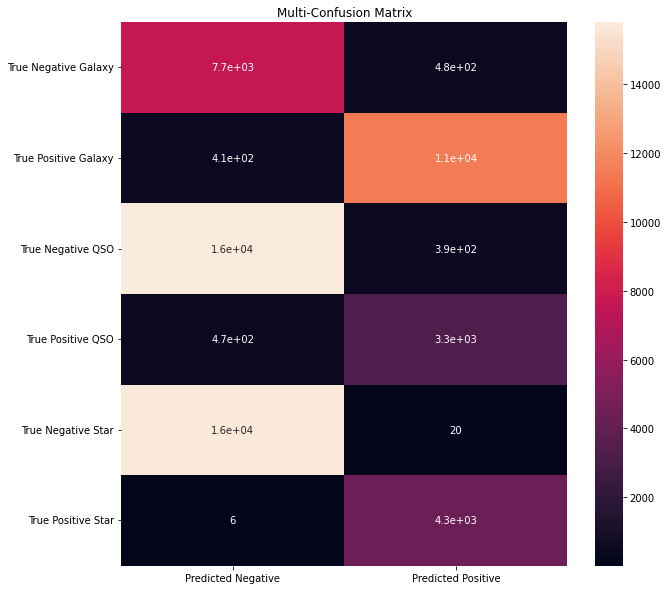

In [156]:
# Resources: https://stackoverflow.com/questions/62722416/plot-confusion-matrix-for-multilabel-classifcation-python
# https://datascience.stackexchange.com/questions/31746/how-to-include-labels-in-sns-heatmap

foo = confusion_matrix.reshape(6,2)
fig, ax = plt.subplots(figsize=(10,10)) 
x_axis_labels = ["Predicted Negative","Predicted Positive"]
y_axis_labels = ["True Negative Galaxy", "True Positive Galaxy", "True Negative QSO", "True Positive QSO","True Negative Star","True Positive Star"]
sns.heatmap(foo, annot = True, xticklabels = x_axis_labels, yticklabels = y_axis_labels)
plt.title("Multi-Confusion Matrix")

## Summary/Takeaways

I learned to <b>always</b> be skeptic of the results, no matter how optimistic I will be. The baseline model raised my suspicion if both accuracy and test sets have such high scores in the 98%.  Despite using 3 features instead of the 10 available, the results are comparable. This saves time and resources in training the model and memory. Once I studied the population and found that the Galaxy Label accounts for half the dataset, I realized I need to perform undersampling techniques.  Although the model suffered a reduction of accuracy score, I believe this is more reasonable. After applying the resampling, metric scores in the final model decreased by .02% - 0.03% when comparing against the baseline model.  I considered using hyperparameter settings, but because I only used 3 features, the default settings is sufficient.

## References/Sources/Credits:

- fedesoriano. (January 2022). Stellar Classification Dataset - SDSS17. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/stellar-classification-dataset-sdss17.
- Abdurro’uf et al., The Seventeenth data release of the Sloan Digital Sky Surveys: Complete Release of MaNGA, MaStar and APOGEE-2 DATA (Abdurro’uf et al. submitted to ApJS) [arXiv:2112.02026]
- https://datascience.stackexchange.com/questions/31746/how-to-include-labels-in-sns-heatmap
- https://stackoverflow.com/questions/62722416/plot-confusion-matrix-for-multilabel-classifcation-python
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
- https://towardsdatascience.com/statistics-in-python-using-anova-for-feature-selection-b4dc876ef4f0
- https://machinelearningmastery.com/feature-selection-with-numerical-input-data/
- https://medium.com/grabngoinfo/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037
- https://stackoverflow.com/questions/48579733/seaborn-subplots-keep-different-x-labels
- https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
- https://www.geeksforgeeks.org/seaborn-kdeplot-a-comprehensive-guide/
- https://www.youtube.com/watch?v=3CC4N4z3GJc

## Feedback/Comments/Suggestions are welcomed and will be credited. 